In [130]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
#from sklearn import cluster
import seaborn as sns

In [131]:
#Global variables
min_layer_thickness = 0.10  # For reference: 0.15m ≈ 0.5ft
mhp_data_file = "SolnorTasch4.mhp"

# EC to stratigraphic categories basic mapping
def EC_to_strat(EC):
    if EC < 0 : 
        raise ValueError("EC<0! Check equipment.")
        sys.exit(0)
    elif 0 <= EC < 0.2 or np.isnan(EC) : 
        return "Asphalte/Gravier"
    elif 0.2 <= EC < 2.5 : 
        return "Sable"
    elif 2.5 <= EC < 10 : 
        return "Silt"
    elif 10 <= EC < 20 :
        return "Silt/Argile"
    else : 
        return "Argile"

# Add 2 col to quantify the span of thin layers: number (#) of 'layers' involved, and sum of their respective thickness 
def instability_span(lith) :
    # Starts with default 0,0...
    lith["Instability Span (#)"] = 0
    lith["Instability Span (m)"] = 0
    # ...then actually compute it for every row
    for i in range(len(lith)) :
        if lith.loc[i, "Thickness(m)"] < min_layer_thickness :
            lith.loc[i, "Instability Span (#)"] += 1
            lith.loc[i, "Instability Span (m)"] += lith.loc[i, "Thickness(m)"]
            if i != 0 :
                if lith.loc[i-1, "Instability Span (#)"] != 0 :
                    lith.loc[i, "Instability Span (#)"] += lith.loc[i-1, "Instability Span (#)"]
                    lith.loc[i, "Instability Span (m)"] += lith.loc[i-1, "Instability Span (m)"]
    return lith

# Drop rows that have consecutive stratigraphy values to aggregate data points by strat layers and compute new depth_f,
# thickness and instability span
def drop_consecutive_strats(lith) :
    index2drop = []
    for i in range(1, len(lith)) :
        if lith.loc[i, "Stratigraphy"] == lith.loc[i-1, "Stratigraphy"] :
            index2drop.append(i)
    lith.drop(index2drop, inplace=True)
    lith.reset_index(drop=True, inplace=True)
    
    # Reset values for final depths
    for i in range(len(lith)-1):
        lith.loc[i, "Depth_f(m)"] = lith.loc[i+1, "Depth_i(m)"]
    lith.loc[len(lith)-1, "Depth_f(m)"] = probe_data.iloc[-1]["Depth (m)"]
    
    # Compute new thickness
    for i in range(len(lith)):
        lith.loc[i, "Thickness(m)"] = lith.loc[i, "Depth_f(m)"] - lith.loc[i, "Depth_i(m)"]
    
    # Compute new isntability span metrics
    lith = instability_span(lith)
    
    return lith

# Note : *This function isn't used in v1.0, but was designed to test more rigorous stats approach that worked 
# decently well for *some* cases and might be useful in later versions. Needed more specific 'detection' in general tho...*
# Detects where fast transitions happen. Takes in dataframe=lithological profile and returns (1)
# the list of indexes of the layers whose thickness is below threshold and (2) their depths (midpoint)

def detect_fast_trans(lith_profile, thickn_threshold = min_layer_thickness): 
    midpoints_thin_layers = []
    index_thin_layers = []
    for index, row in lith_profile.iterrows() :
        if float(row["Thickness(m)"]) < thickn_threshold :
            index_thin_layers.append(index)
            midpoints_thin_layers.append(round(row["Depth_i(m)"] + 0.5*row["Thickness(m)"], 5))            
    return [index_thin_layers, midpoints_thin_layers]


# This function takes in the partial dataframe defined by a long (>min_oscillations) unstable layer,  
# then pivots the table on the total span (in m) of each components, and returns the dominant if its above 60%,
# or a newly defined hybrid layer if the second layer is between 40-50%             
def oscillation_distr(p_df) :
    dominant_threshold = 0.6
    piv =  p_df.pivot_table(index="Stratigraphy", values="Instability Span (m)", aggfunc=sum)

    total_lenght = piv["Instability Span (m)"].sum()
    piv["Percent"] = piv["Instability Span (m)"]/total_lenght
    piv.sort_values("Percent", ascending=False, inplace=True)
    
    if piv["Percent"].iloc[0] > dominant_threshold :
        return piv.index[0]
    elif 0.5 > piv["Percent"].iloc[1] > 0.4 : 
        return piv.index[0] + "+" + piv.index[1]
    else : # if none of above conditions are true, there's a significant third element but return first anyway for now
        return piv.index[0]  
    # TODO: it's possible to oscillate between 2 layers and quicky jump to a stable while "passing by" a third unstable 
    # for, say, 0.9*min_thickness_layer, or something of the sort. Should perhaps think deeper about what to do there...
    
    

# This is the main "cleaning" function. It calls 3 other functions (and after computing their relevant arguments) 
# to cover the 3 possible ways a strat can be too thin : (1) oscillation at the boundery, (2) spike in the data and (3) 
# "skipping" a layer (e.g. going straight from Asphalte to Argile). The way it does that is to check the stable points
# and decide what to do with their preceding unstable region depending on the instability span
def oscillation_cleanup(lith, min_oscillations = 4) :
    stable_layers_index = lith[lith["Instability Span (#)"] == 0].index # list stable poits
    for i in range(len(stable_layers_index)) :
        index = stable_layers_index[i]
        if index == 0 :
            continue # if the first stable strat is the first start, no previous strat to check (which is how this fct works)
        else:
            if lith.loc[index-1, "Instability Span (#)"] >= min_oscillations :
                start = stable_layers_index[i-1]+1
                end = stable_layers_index[i]-1
                unstbl_layer = lith.loc[start:end, ["Stratigraphy", "Instability Span (m)"]]
                dominant = oscillation_distr(unstbl_layer)
                
                for j in range(start, end+1) :
                    lith.loc[j, "Stratigraphy"] = dominant
    lith = drop_consecutive_strats(lith)
    return lith

# Deals with spikes in data by replacing them with the value of the previous strat. Beginning is similar to osc_cleanup 
# but have to be separated cause they are applied one after the other, and not as 'if, elif' conditions (...to avoid 
# treating oscillations as spikes, we have to return the dataframe processed, then treat spikes)

def spike_cleanup(lith, spikes_max_span = 2*0.016) :  # a spike is max 2 data points (0.015m/data point but sometimes we see 0.031m for 2)
    stable_layers_index = lith[lith["Instability Span (#)"] == 0].index # list stable poits
    for i in range(len(stable_layers_index)) :
        stbl_index = stable_layers_index[i]
        if i != 0 :
            prev_stbl_index = stable_layers_index[i-1]
        if stbl_index == 0 :
            continue #this fct detect spikes by looking at layers preceding a stable one, which doesnt work for the first
        elif lith.loc[stbl_index-1, "Instability Span (m)"] == 0 :
            continue # previous layer is stable, i.e. not a spike, so go on next i
        else :
            if lith.loc[stbl_index-1, "Instability Span (m)"] <= spikes_max_span :
                #with open('log.out', 'a') as ofile : ofile.write(str(lith.loc[stbl_index-1, "Instability Span (m)"]) + ', ' + str(lith.loc[stbl_index-1, "Stratigraphy"]) + ', ' + str(lith.loc[stbl_index-2, "Stratigraphy"]) )
                lith.loc[stbl_index-1, "Stratigraphy"] = lith.loc[stbl_index-2, "Stratigraphy"] 
    lith = drop_consecutive_strats(lith)        
    return lith

# Despite the "raw" categorization values, asphalte and NA values are almost always in the first layer
def clean_deep_asphalte(lith) :
    for index, row in lith.iterrows():
        if index !=0 and row["Stratigraphy"] == "Asphalte/Gravier":
            lith.loc[index, "Stratigraphy"] = "Gravier"
    return lith

# We'll never see "Gravier" alone if there is sand just above
def add_finer_grain_to_gravier_if_below(lith) : 
    for i in range(1,len(lith)):
        if lith.loc[i, "Stratigraphy"] == "Gravier" and "Sable" in lith.loc[i-1, "Stratigraphy"]:
            lith.loc[i, "Stratigraphy"] = "Gravier+Sable"
        if lith.loc[i, "Stratigraphy"] == "Gravier" and "Silt" in lith.loc[i-1, "Stratigraphy"]:
            lith.loc[i, "Stratigraphy"] = "Gravier+Silt"
        if lith.loc[i, "Stratigraphy"] == "Gravier" and "Silt" in lith.loc[i-1, "Stratigraphy"] and "Sable" in lith.loc[i-1, "Stratigraphy"]:
            lith.loc[i, "Stratigraphy"] = "Gravier+Silt+Sable"    
    lith = drop_consecutive_strats(lith)
    return lith

# More of an common sense sort of processing : it treats layers # that doesnt oscillate (span # =1) but stil below 
# min_layer_thickness as part of its surronding if below and above layers are the same. Call it after all the rest.
def incorporate_unst_lay_to_surroundings_if_heterogen(lith):
    for i in range(1,len(lith)-1):
        if lith.loc[i, "Instability Span (#)"] == 1 and lith.loc[i, "Instability Span (m)"] < min_layer_thickness and lith.loc[i-1, "Stratigraphy"] == lith.loc[i+1, "Stratigraphy"]:
            lith.loc[i, "Stratigraphy"] = lith.loc[i-1, "Stratigraphy"]
    lith = drop_consecutive_strats(lith)        
    return lith

def convert_to_strater(lith, units="m", hole_id=1):
    
    def meter_to_feet(x) :
        return round(3.28084*x, 2)
    
    log = lith.loc[:, ["Depth_i(m)", "Depth_f(m)", "Stratigraphy"]]
    log["Hole ID"] = hole_id # defaults to 1 in version 1.0, to be changed later when (if?) implementing cross-sections
    log = log[["Hole ID", "Depth_i(m)", "Depth_f(m)", "Stratigraphy"]] #reorder
    log.columns = ["Hole ID", "From", "To", "Lithology Keyword"] #rename
    if units == "ft" :
        log["From"] = log["From"].apply(meter_to_feet)
        log["To"] = log["To"].apply(meter_to_feet)
    
    outfile_name = mhp_data_file.split(".")[0] + "-hole" + str(hole_id) + ".xls"
    log.to_excel(outfile_name, index=False)
    
    return outfile_name + " successfully created." 


In [132]:
probe_data = pd.read_csv(mhp_data_file, sep='\t')

######## Plots the EC data ############
#fig = plt.figure(figsize=[8,8])
#axes = fig.add_axes([0.1,0.1,0.8,0.8])
#axes.plot(probe_data["EC (mS/m)"], probe_data["Depth (m)"])
#axes.set_ylim(axes.get_ylim()[::-1])
#plt.xlabel("Electroconductivity (mS/m)")
#plt.ylabel("Depth (m)")
#plt.yticks(np.arange(0, int(probe_data["Depth (m)"].max() + 1), step=0.25))
#plt.xticks(np.arange(0, int(1.05*probe_data["EC (mS/m)"].max() ), step=10))
#plt.grid()

############ Uncomment block below to also plot rolling average (TODO : left-skewed window to fix!) ############
#rolling_window = 10
#rolling_data = list(np.convolve(probe_data["EC (mS/m)"], np.ones((rolling_window,))/rolling_window, mode='valid'))
#slope_end = rolling_data[-1]-rolling_data[-(rolling_window]
#for i in range(rolling_window-1) : rolling_data.append(rolling_data[-1])
#axes.plot(rolling_data, probe_data["Depth (m)"], )


# Extract depth and converted EC data, rename col and drop rows with consecutive stratigraphy values 
lith = pd.concat([probe_data["Depth (m)"], probe_data["EC (mS/m)"].apply(EC_to_strat)], axis = 1)
lith.columns = ["Depth_i(m)", "Stratigraphy"] 
lith = drop_consecutive_strats(lith)

# Reorder columns
lith = lith[["Depth_i(m)", "Depth_f(m)", "Thickness(m)", "Stratigraphy"]] 

# Basic cleanup
lith = clean_deep_asphalte(lith)
lith = add_finer_grain_to_gravier_if_below(lith)

# Compute instability metrics and add them to new comlums
lith = instability_span(lith)

# Process the data to get rid of oscillations, spikes, artefact-y fast transitions (eg tryign to erase 2 if doesnt               
# exist when going from 1 to 3)  (the last part isn't perfect in v1.0)
lith = oscillation_cleanup(lith)
lith = spike_cleanup(lith)

# Important to use the following after every other cleaning steps.. 
lith = incorporate_unst_lay_to_surroundings_if_heterogen(lith)

# Save .xls. Remove the 2nd and 3rd argument altogether to default to meters and hole_id=1 respectively
convert_to_strater(lith, 'ft', 1) 

'SolnorTasch4-hole1.xls successfully created.'

In the cell below, I tried computing the Kernel Density Estimate with seaborn library in order to see if we could implement a rigorous approach to calculating the span of unstable transitions. The idea would be to compute the full width at half maximum (FWHM) to predict the right transitions. It makes rather good predictions in most well-behaved cases, so it's an approach worth remembering.

Unfortunately, for ./Tasch1/SolnorTasch4.mhp -- one of the most problematic curve with respect to transitions --, this approach merged the ‘sable-gravier’ region with the ‘argile-silt/argile’ region. When different unstable regions are too close to each others, we need a way to distinguish them, so I don't think using KDE's FWHM is the best approach in those cases. The same problem would arise for other classification methods (e.g. Jenks natural breaks classification method) unless we figure out way to implement them with some sort of pre-established labels.

Therefore, I think we're better off with a ‘home-made'(non statistical) approach to classification, since choising the appropriate method for selecting the so-called "pre-established labels" would be a classification method in itself...

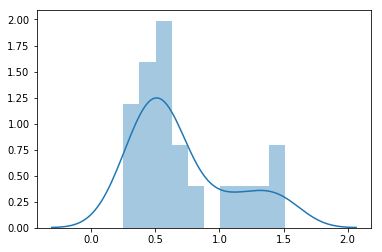

In [122]:
# Make a distplot with KDE with bins defined by the caracteristic lenght of the categorization problem
sns.distplot(a=detect_fast_trans(lith)[1], bins=int(1/min_layer_thickness))